In [1]:
import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = datasets.load_dataset("matsant01/dit-editor-collected-preferences", split="train").to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
print("{} total votes".format(len(df)))
print("{} unique sessions".format(len(df["session_id"].unique())))

# A session is completed if the user has voted on 12 items
completed_df = df.groupby("session_id").filter(lambda x: len(x) == 12)
print("{} completed sessions".format(len(completed_df["session_id"].unique())))

882 total votes
90 unique sessions
60 completed sessions


In [4]:
df["preferred_model_key"] = df["preferred_model_key"].apply(lambda x: x if x != "dit-editor" else "ours")

### Not aggregated (overall averages, not per session)

/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_68995/3051108164.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = completed_df.groupby("session_id").apply(normalize_votes).reset_index()


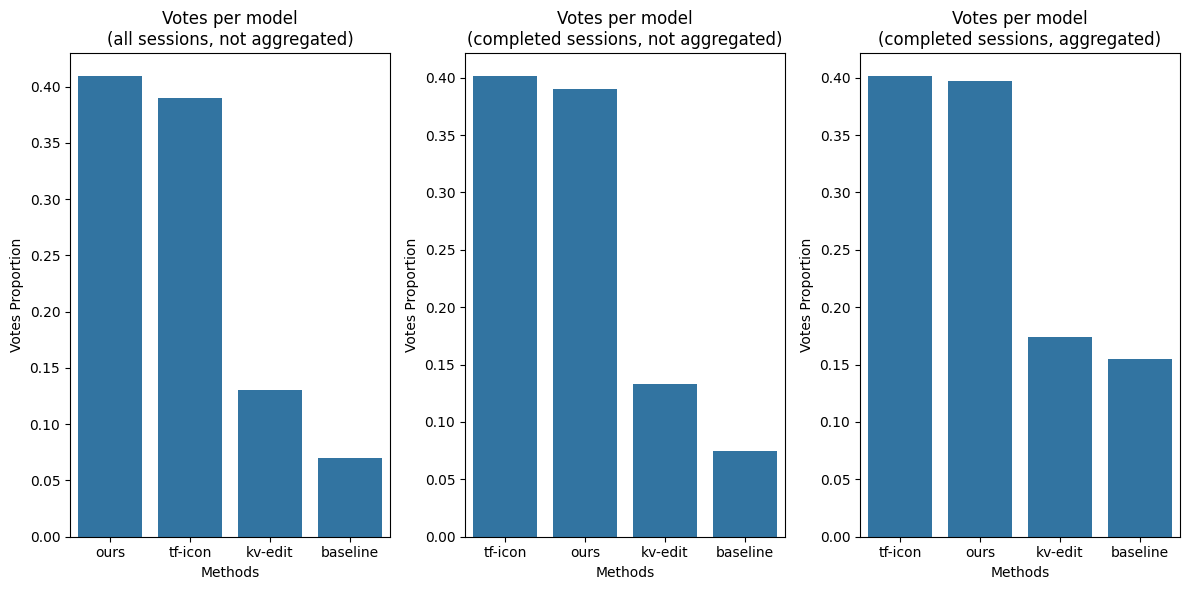

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Simplest barplot (all sessions, independent votes)
sns.barplot(df["preferred_model_key"].value_counts(normalize=True), ax=axs[0])
axs[0].set_title("Votes per model\n(all sessions, not aggregated)")
axs[0].set_xlabel("Methods")
axs[0].set_ylabel("Votes Proportion")

# Complete sessions only, independent votes
completed_df = df.groupby("session_id").filter(lambda x: len(x) == 12)
sns.barplot(completed_df["preferred_model_key"].value_counts(normalize=True), ax=axs[1])
axs[1].set_title("Votes per model\n(completed sessions, not aggregated)")
axs[1].set_xlabel("Methods")
axs[1].set_ylabel("Votes Proportion")

def normalize_votes(session):
    votes = session["preferred_model_key"].value_counts()
    return votes / votes.sum()

# For each session we count the votes for each model and normalize them
normalized_df = completed_df.groupby("session_id").apply(normalize_votes).reset_index()
normalized_df = normalized_df[["preferred_model_key", "count"]].groupby("preferred_model_key").mean().reset_index()
normalized_df.sort_values(by="count", ascending=False, inplace=True)
sns.barplot(data=normalized_df, x="preferred_model_key", y="count", ax=axs[2])
axs[2].set_title("Votes per model\n(completed sessions, aggregated)")
axs[2].set_xlabel("Methods")
axs[2].set_ylabel("Votes Proportion")

plt.tight_layout()

In [6]:
df["preferred_model_key"].value_counts().reset_index()

,preferred_model_key,count
0,ours,361
1,tf-icon,344
2,kv-edit,115
3,baseline,62


In [7]:
df["domain"].value_counts().reset_index()

,domain,count
0,Real-Real,224
1,Real-Sketch,223
2,Real-Cartoon,222
3,Real-Painting,213


/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_68995/526636766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df["preferred_model_key"].value_counts().reset_index(), x="count", y="preferred_model_key", palette="viridis", )


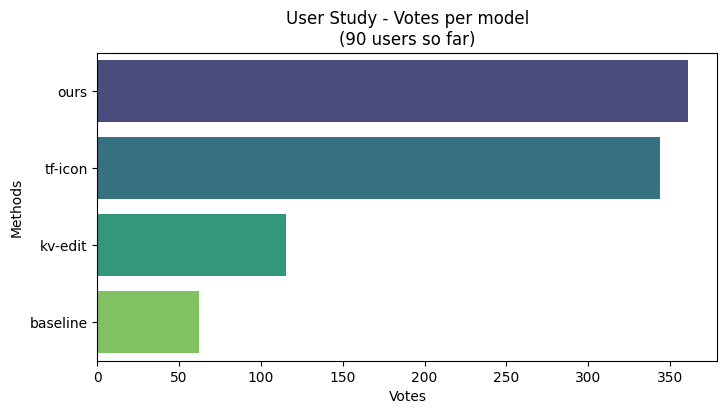

In [8]:
# Simplest barplot (all sessions, independent votes)
plt.figure(figsize=(8, 4))
sns.barplot(data=df["preferred_model_key"].value_counts().reset_index(), x="count", y="preferred_model_key", palette="viridis", )
plt.title(f"User Study - Votes per model\n({len(df['session_id'].unique())} users so far)")
plt.ylabel("Methods")
plt.xlabel("Votes")
plt.savefig("dit-editor-collected-preferences.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 1200x600 with 0 Axes>

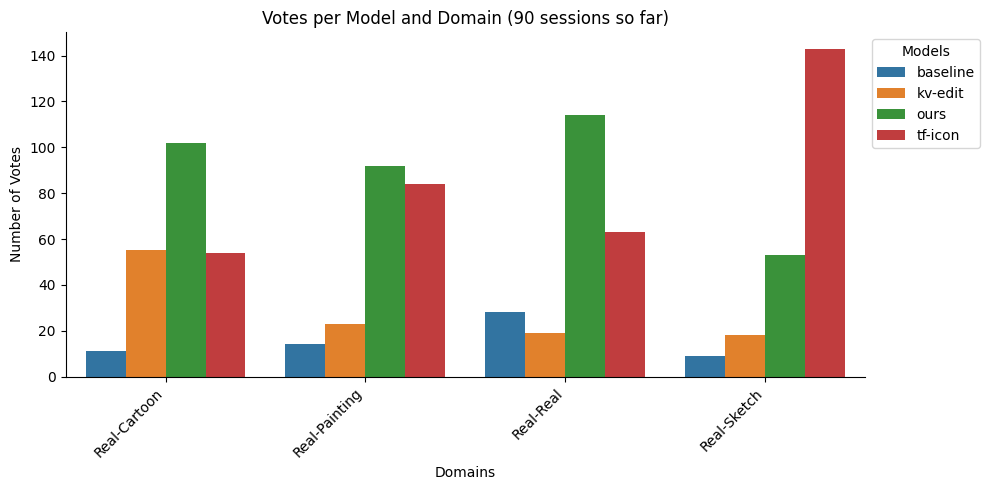

<Figure size 1200x600 with 0 Axes>

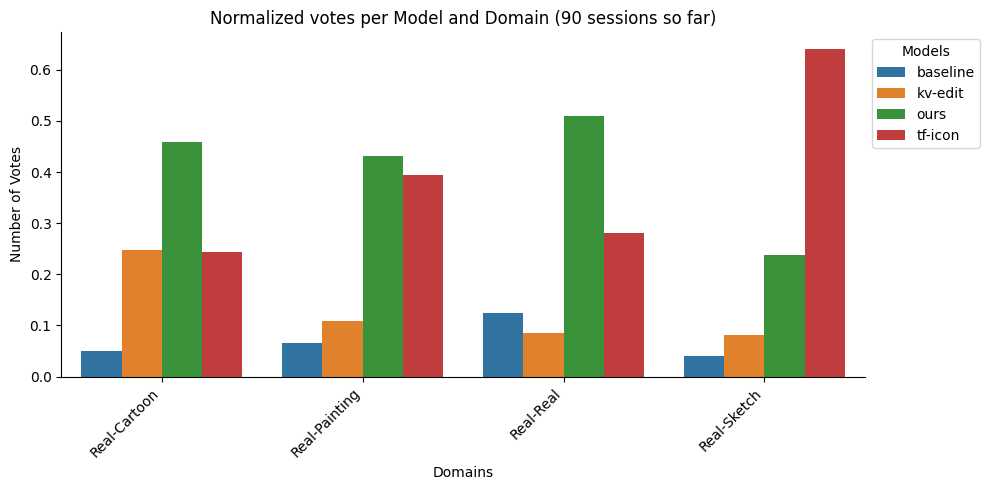

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by preferred_model_key and domain, then count
grouped_df = df.groupby(["preferred_model_key", "domain"]).size().reset_index(name="count")
norm_values = grouped_df.groupby("domain")["count"].sum().reset_index()
grouped_df["norm_count"] = grouped_df["count"] / grouped_df["domain"].map(dict(zip(norm_values["domain"], norm_values["count"])))
# Create the barplot
plt.figure(figsize=(12, 6))
sns.catplot(
    data=grouped_df,
    x="domain",
    y="count",
    hue="preferred_model_key",
    kind="bar",

    aspect=2, # Adjust aspect ratio for better visualization
    legend_out=False,
)
plt.legend([],[], frameon=False)
plt.title("Votes per Model and Domain ({} sessions so far)".format(len(df["session_id"].unique())))
plt.xlabel("Domains")
plt.ylabel("Number of Votes")
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
plt.legend(title="Models", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# Group by preferred_model_key and domain, then count
grouped_df = df.groupby(["preferred_model_key", "domain"]).size().reset_index(name="count")
norm_values = grouped_df.groupby("domain")["count"].sum().reset_index()
grouped_df["norm_count"] = grouped_df["count"] / grouped_df["domain"].map(dict(zip(norm_values["domain"], norm_values["count"])))
# Create the barplot
plt.figure(figsize=(12, 6))
sns.catplot(
    data=grouped_df,
    x="domain",
    y="norm_count",
    hue="preferred_model_key",
    kind="bar",

    aspect=2, # Adjust aspect ratio for better visualization
    legend_out=False,
)
plt.legend([],[], frameon=False)
plt.title("Normalized votes per Model and Domain ({} sessions so far)".format(len(df["session_id"].unique())))
plt.xlabel("Domains")
plt.ylabel("Number of Votes")
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
plt.legend(title="Models", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("dit-editor-collected-preferences-domain.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:

# Is there any random voting?

## Group by session_id and count the number of votes
sessions = df.groupby("session_id").size().reset_index(name="count")
print("Sessions with only one vote: {}".format(len(sessions[sessions["count"] == 1])))

## Are there sessions with nearly random votes?
session_model_votes = df.groupby(["session_id", "preferred_model_key"]).size().reset_index(name="vote_count")
print(session_model_votes.head())



Sessions with only one vote: 4
         session_id preferred_model_key  vote_count
0  03a0baa9971a499d             tf-icon           2
1  03f7240d299f440e             kv-edit           1
2  03f7240d299f440e                ours           3
3  03f7240d299f440e             tf-icon           3
4  045f62d496034475             kv-edit           4


In [11]:
## Are there sessions with nearly random votes?
session_model_votes = df.groupby(["session_id", "preferred_model_key"]).size().reset_index(name="vote_count")
print(session_model_votes.head())

# Ensure completed_df is defined (e.g., from a previous cell: completed_df = df.groupby("session_id").filter(lambda x: len(x) == 12))
# If not, uncomment and run:
# completed_df = df.groupby("session_id").filter(lambda x: len(x) == 12)

print(f"\nAnalyzing {len(completed_df['session_id'].unique())} completed sessions...")

# Get vote counts per model for each completed session
completed_session_model_votes = completed_df.groupby(["session_id", "preferred_model_key"]).size().reset_index(name="vote_count")

# Pivot the table to have models as columns, sessions as rows
# This ensures that if a model received 0 votes in a session, it's represented with a 0
session_vote_distribution = completed_session_model_votes.pivot_table(
    index="session_id",
    columns="preferred_model_key",
    values="vote_count",
    fill_value=0  # Fill with 0 for models not voted for in a session
)

# Get the list of model names that are columns in session_vote_distribution
model_columns = session_vote_distribution.columns.tolist()

# Calculate the standard deviation of votes across models for each session
# A low std dev indicates votes are more evenly distributed (more random-like)
session_vote_distribution['std_dev_votes'] = session_vote_distribution[model_columns].std(axis=1)

# Sort sessions by the standard deviation of their vote distributions
nearly_random_sessions_sorted = session_vote_distribution.sort_values(by='std_dev_votes')

print("\nTop sessions with the most evenly distributed (random-like) votes (lowest std dev):")
print(nearly_random_sessions_sorted.head())

# Define a threshold for "nearly random" based on standard deviation
# For 12 votes and 3 models, perfect random [4,4,4] has std=0.
# A distribution like [3,4,5] has std approx 0.816.
std_dev_threshold = 1.0  # Adjust this threshold as needed
identified_nearly_random_sessions = nearly_random_sessions_sorted[nearly_random_sessions_sorted['std_dev_votes'] < std_dev_threshold]

if not identified_nearly_random_sessions.empty:
    print(f"\nFound {len(identified_nearly_random_sessions)} sessions with vote std_dev < {std_dev_threshold} (potentially nearly random):")
    print(identified_nearly_random_sessions)
else:
    print(f"\nNo sessions found with vote std_dev < {std_dev_threshold}.")

# Alternative check: sessions where no single model dominates excessively
# Calculate the maximum number of votes any single model received in each session
session_vote_distribution['max_vote_for_model'] = session_vote_distribution[model_columns].max(axis=1)
num_models = len(model_columns)
ideal_random_vote_per_model = 12 / num_models if num_models > 0 else 12 # 12 total votes in a completed session

# Consider sessions where the max vote isn't too far from the ideal random average
# For example, if max vote is <= ideal_random_vote_per_model + 1 or + 2
max_vote_threshold = ideal_random_vote_per_model + 1 # e.g., for 3 models, ideal is 4, threshold is 5

potentially_random_by_max_vote = session_vote_distribution[
    session_vote_distribution['max_vote_for_model'] <= max_vote_threshold
].sort_values(by='std_dev_votes')

if not potentially_random_by_max_vote.empty:
    print(f"\nSessions where the max vote for any model is <= {int(max_vote_threshold)} (another indicator of distributed voting):")
    print(potentially_random_by_max_vote[[*model_columns, 'std_dev_votes', 'max_vote_for_model']])
else:
    print(f"\nNo sessions found where the max vote for any model is <= {int(max_vote_threshold)}.")


         session_id preferred_model_key  vote_count
0  03a0baa9971a499d             tf-icon           2
1  03f7240d299f440e             kv-edit           1
2  03f7240d299f440e                ours           3
3  03f7240d299f440e             tf-icon           3
4  045f62d496034475             kv-edit           4

Analyzing 60 completed sessions...

Top sessions with the most evenly distributed (random-like) votes (lowest std dev):
preferred_model_key  baseline  kv-edit  ours  tf-icon  std_dev_votes
session_id                                                          
3890c8ced21b495b          2.0      3.0   4.0      3.0       0.816497
9619debd8212405e          2.0      2.0   4.0      4.0       1.154701
0b9709eda885486e          1.0      3.0   4.0      4.0       1.414214
71cb824d546f488d          2.0      3.0   5.0      2.0       1.414214
1b369277543748e0          2.0      3.0   5.0      2.0       1.414214

Found 1 sessions with vote std_dev < 1.0 (potentially nearly random):
preferred_mod